In [65]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

In [66]:
df = pd.read_csv("OriginalData.csv")

In [62]:
df.columns

Index(['Ringnummer', 'Taggnummer', 'Typ', 'Kön', 'Våtmark', 'Vikt', 'Date',
       'År', 'Månad', 'Dag', 'Julian day', ' Time', 'Timme', 'Minut', 'sekund',
       'Juliansk tid', 'Tidsskillnad', 'Antal dagar', ' Latitude',
       ' Longitude', ' Altitude', ' Speed (m/h)', ' Course', ' Distance'],
      dtype='object')

In [63]:
df

,Ringnummer,Taggnummer,Typ,Kön,Våtmark,Vikt,Date,År,Månad,Dag,...,sekund,Juliansk tid,Tidsskillnad,Antal dagar,Latitude,Longitude,Altitude,Speed (m/h),Course,Distance
0,90B05524,73,0,0,Fällan,992,9/12/2012,2012,9,12,...,58,1058974378,3564.0,4,56.440033,13.992838,114.75,540,351,737.60
1,90B05524,73,0,0,Fällan,992,9/12/2012,2012,9,12,...,22,1058977942,3449.0,NaN,56.439972,13.992728,110.88,396,210,9.58
2,90B05524,73,0,0,Fällan,992,9/12/2012,2012,9,12,...,51,1058981391,3493.0,NaN,56.440144,13.992794,93.94,252,337,19.55
3,90B05524,73,0,0,Fällan,992,9/12/2012,2012,9,12,...,4,1058984884,161899.0,NaN,56.440147,13.992643,103.27,540,32,9.29
4,90B05524,73,0,0,Fällan,992,9/14/2012,2012,9,14,...,23,1059146783,3670.0,NaN,56.439632,13.992536,89.84,0,190,59.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19910,90B07548,111,0,1,Fällan,1438,10/3/2012,2012,10,3,...,46,1060800406,3596.0,NaN,56.440178,13.992034,105.95,108,358,80.75
19911,90B07548,111,0,1,Fällan,1438,10/3/2012,2012,10,3,...,42,1060804002,3622.0,NaN,56.439957,13.992407,104.58,0,137,33.61
19912,90B07548,111,0,1,Fällan,1438,10/3/2012,2012,10,3,...,4,1060807624,3749.0,NaN,56.440022,13.992071,103.86,1008,277,21.88
19913,90B07548,111,0,1,Fällan,1438,10/3/2012,2012,10,3,...,33,1060811373,3566.0,NaN,56.440029,13.992332,95.84,360,2,16.06


## Pre-processesing 

In [64]:

df['Date'] = pd.to_datetime(df['Date'])
df['Datetime'] = pd.to_datetime(df[['Date', 'Timme', 'Minut', 'sekund']].astype(str).agg(' '.join, axis=1), format='%Y-%m-%d %H %M %S')
df['Date'] = pd.to_datetime(df['Datetime'])


mpl_datetime = df['Datetime'].apply(lambda x: x.timestamp())

df[' Altitude'] = pd.to_numeric(df[' Altitude'], errors='coerce')
df = df.dropna()
encoder = LabelEncoder()
df['Våtmark'] = encoder.fit_transform(df['Våtmark'])
df = pd.get_dummies(df, columns=['Våtmark'])

# set the Datetime column as the index
df.set_index('Datetime', inplace=True)
# convert the time column to a datetime object
df['Timme'] = pd.to_datetime(df['Timme'])


# group the data by day and calculate the mean altitude and speed for each hour,day,month
daily_data = df.groupby(pd.Grouper(freq='D')).mean()
monthly_data = df.groupby(pd.Grouper(freq='M')).mean()
hourly_data = df.groupby(df['Timme'].dt.hour)[' Speed (m/h)'].mean().reset_index()



print(df)

                    Ringnummer  Taggnummer  Typ  Kön  Vikt  \
Datetime                                                     
2012-09-12 15:32:58   90B05524          73    0    0   992   
2012-08-21 15:48:53   90B05588           3    0    1  1504   
2012-09-06 17:13:07   90B05588          69    0    1  1504   
2012-09-06 15:15:20   90B05590          57    0    0  1148   
2012-08-24 15:23:34   90B05592          31    0    0  1089   
...                        ...         ...  ...  ...   ...   
2012-09-14 16:43:05   90B07543          88    0    1  1184   
2012-09-04 00:59:24   90B07544          48    0    0  1250   
2012-09-19 15:08:45   90B07544         113    0    0  1250   
2012-09-04 00:54:14   90B07548          49    0    1  1438   
2012-09-19 15:26:06   90B07548         111    0    1  1438   

                                   Date    År  Månad  Dag  Julian day  ...  \
Datetime                                                               ...   
2012-09-12 15:32:58 2012-09-12 15:32:

/var/folders/fq/x1sslcf904b46lvn63t6cwt80000gn/T/ipykernel_3406/744541782.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Våtmark'] = encoder.fit_transform(df['Våtmark'])


## Clustering

In [51]:
# select the features for clustering
X = df[[' Latitude', ' Longitude', ' Altitude']]
# set the number of clusters
k = 5

# apply the k-means clustering algorithm
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

## Cohesion and Validation on Longitude and Latitude

In [52]:
# calculate the cohesion of each cluster
coh = []
for i in range(k):
    dist = cdist(X[kmeans.labels_ == i], [kmeans.cluster_centers_[i]])
    coh.append(dist.mean())
# calculate the separation between each pair of clusters
sep = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_).max()

# estimate the validation score
valid_score = sum(coh) / sep

print('Validation score: {}'.format(valid_score))

Validation score: 0.1740159421327156


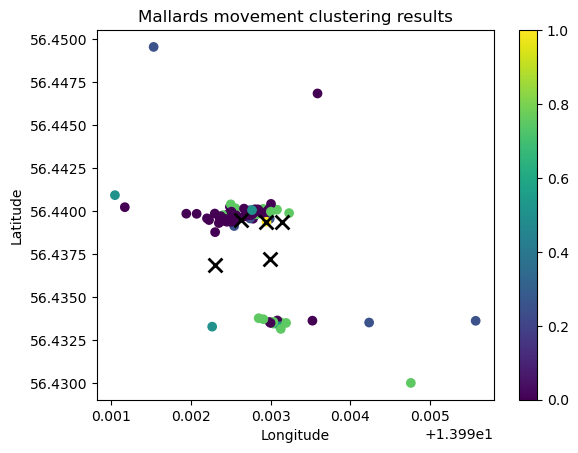

In [53]:
# create a scatter plot of the data with color-coded clusters
plt.scatter(X[' Longitude'], X[' Latitude'], c=kmeans.labels_, cmap='viridis')

# add the centroids to the plot
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], marker='x', s=100, linewidths=2, color='black')

# add a legend and labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mallards movement clustering results')
plt.colorbar()

# display the plot
plt.show()

## Time serie analysis 

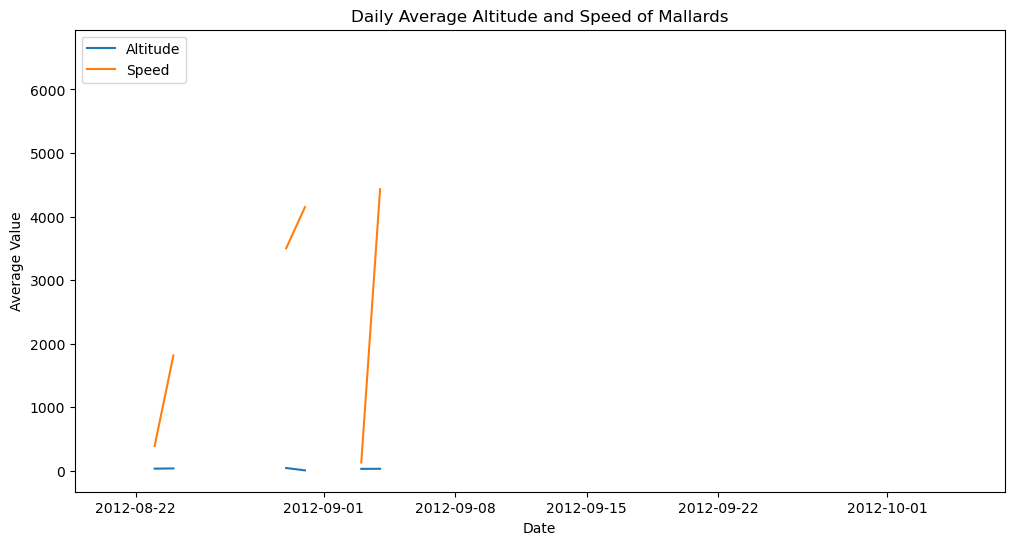

In [55]:
# convert altitude from feet to meters
daily_data[' Altitude (m)'] = daily_data[' Altitude'] * 0.3048

# convert speed from meters per second to kilometers per hour
daily_data[' Speed (km/h)'] = daily_data[' Speed (m/h)'] * 3.6

# create a line plot of the daily altitude and speed
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_data[' Altitude (m)'], label='Altitude')
ax.plot(daily_data[' Speed (km/h)'], label='Speed')
ax.set_xlabel('Date')
ax.set_ylabel('Average Value')
ax.set_title('Daily Average Altitude and Speed of Mallards')
ax.legend()
plt.show()

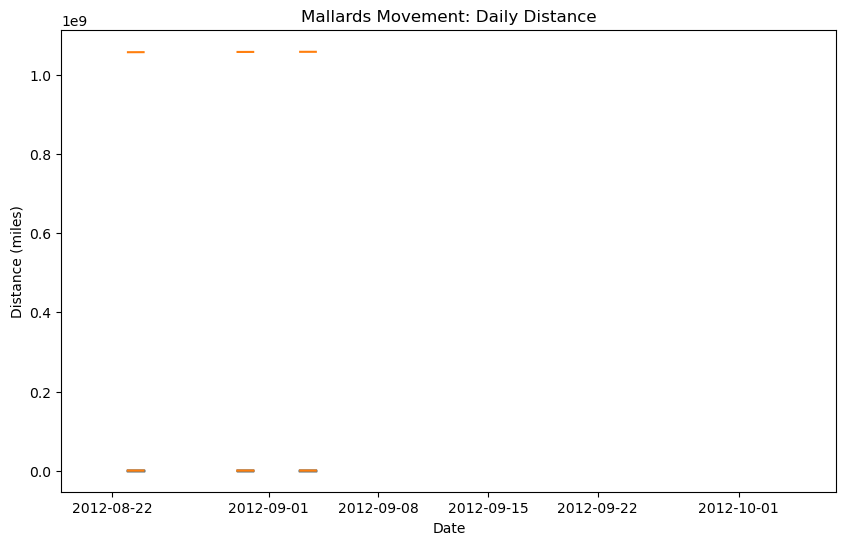

In [39]:
# create a line plot of distance over time
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data.values)
plt.title('Mallards Movement: Daily Distance')
plt.xlabel('Date')
plt.ylabel('Distance (miles)')
plt.show()

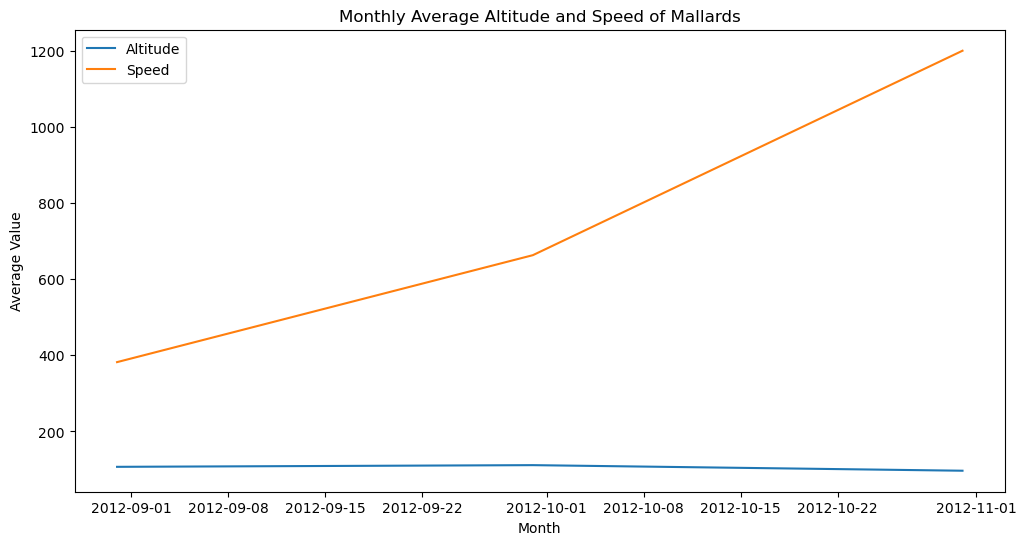

In [40]:
# create a line plot of the monthly average altitude and speed
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_data[' Altitude'], label='Altitude')
ax.plot(monthly_data[' Speed (m/h)'], label='Speed')
ax.set_xlabel('Month')
ax.set_ylabel('Average Value')
ax.set_title('Monthly Average Altitude and Speed of Mallards')
ax.legend()
plt.show()

In [57]:
# fit a linear regression model to the data
X = hourly_data['Timme'].values.reshape(-1, 1)
y = hourly_data[' Speed (m/h)'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

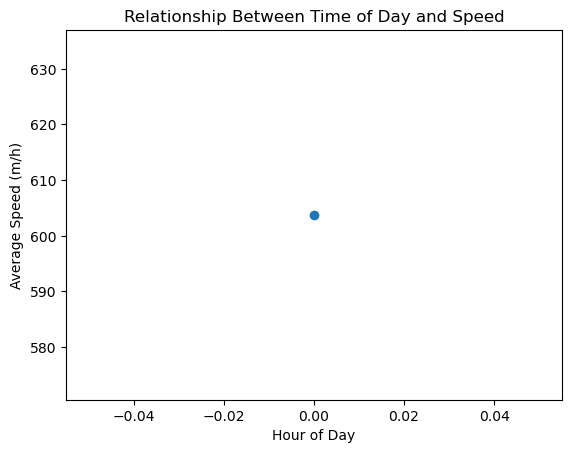

Intercept: 603.75
Slope: 0.0
R-squared: nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [59]:
# plot the data and the regression line
fig, ax = plt.subplots()
ax.scatter(hourly_data['Timme'], hourly_data[' Speed (m/h)'])
ax.plot(X, model.predict(X), color='red')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Speed (m/h)')
ax.set_title('Relationship Between Time of Day and Speed')
plt.show()

# print the regression coefficients
print('Intercept:', model.intercept_[0])
print('Slope:', model.coef_[0][0])
print('R-squared:', model.score(X, y))